In [ ]:
!nvidia-smi -L || true
!pip -q install -U transformers datasets accelerate
!pip -q install pandas numpy scikit-learn matplotlib openpyxl tqdm
!pip -q install jieba wordcloud


GPU 0: NVIDIA GeForce RTX 3080 (UUID: GPU-1aabc485-e859-e06c-0d3d-ab86a38f901d)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 11.1 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

Fri Jan 16 14:36:25 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.07             Driver Version: 581.80         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080        On  |   00000000:01:00.0  On |                  N/A |
| 53%   36C    P0             96W /  340W |    1253MiB /  10240MiB |      7%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score


##配置：文件路径与列名




In [ ]:
TEXT_COL  = 'text'
LABEL_COL = 'final_label'

TRAIN_FILE = '/content/train_llm_4800.xlsx'
TEST_FILES = {
    'test_llm_1200':  '/content/test_llm_1200.xlsx',
    'test_human_400': '/content/test_human_400.xlsx',
}

assert os.path.exists(TRAIN_FILE), f'找不到: {TRAIN_FILE}'
for k,v in TEST_FILES.items():
    assert os.path.exists(v), f'找不到: {v}'

print('OK: files exist')


OK: files exist


##读取与清洗数据

In [ ]:
def clean_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df[TEXT_COL]  = df[TEXT_COL].astype(str).str.strip()
    df[LABEL_COL] = df[LABEL_COL].astype(str).str.strip()
    df = df.dropna(subset=[TEXT_COL, LABEL_COL])
    df = df[(df[TEXT_COL] != '') & (df[LABEL_COL] != '')]
    return df

df_train = clean_df(pd.read_excel(TRAIN_FILE))
test_dfs = {name: clean_df(pd.read_excel(path)) for name, path in TEST_FILES.items()}

print('Train:', len(df_train))
for name, df in test_dfs.items():
    print(name, ':', len(df))

print('Columns (train):', list(df_train.columns))
print('Columns (human):', list(test_dfs['test_human_400'].columns))


Train: 4790
test_llm_1200 : 1203
test_human_400 : 396
Columns (train): ['text', 'final_label']
Columns (human): ['text', 'final_label']


##标签编码（与训练集对齐）

In [ ]:
le = LabelEncoder()
le.fit(df_train[LABEL_COL].values)
classes = list(le.classes_)
print('Classes:', classes)

X_train_text = df_train[TEXT_COL].tolist()
y_train = le.transform(df_train[LABEL_COL].values)


Classes: ['neg', 'neu', 'pos']


##CroBERTa fine-tuned（Trainer）

In [ ]:
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding

os.environ['WANDB_DISABLED'] = 'true'
os.environ['WANDB_MODE'] = 'disabled'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

HF_MODEL_NAME = 'hfl/chinese-roberta-wwm-ext'

tokenizer = AutoTokenizer.from_pretrained(HF_MODEL_NAME)

def build_dataset(texts, labels):
    return Dataset.from_dict({'text': list(texts), 'label': list(labels)})

# train
train_ds = build_dataset(X_train_text, y_train)

# test_llm_1200
df_test_llm = test_dfs['test_llm_1200']
X_test_llm = df_test_llm[TEXT_COL].tolist()
y_test_llm = le.transform(df_test_llm[LABEL_COL].values)
test_llm_ds = build_dataset(X_test_llm, y_test_llm)

# human_400
df_gold = test_dfs['test_human_400']
X_gold = df_gold[TEXT_COL].tolist()
y_gold = le.transform(df_gold[LABEL_COL].values)
gold_ds = build_dataset(X_gold, y_gold)

def tokenize_fn(batch):
    return tokenizer(batch['text'], truncation=True, padding=False, max_length=128)

train_ds = train_ds.map(tokenize_fn, batched=True)
test_llm_ds = test_llm_ds.map(tokenize_fn, batched=True)
gold_ds = gold_ds.map(tokenize_fn, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model = AutoModelForSequenceClassification.from_pretrained(
    HF_MODEL_NAME,
    num_labels=len(classes)
).to(device)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {'accuracy': accuracy_score(labels, preds)}

common_args = dict(
    output_dir='./croberta_output',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    report_to='none'
)

try:
    training_args = TrainingArguments(**common_args, evaluation_strategy='epoch')
except TypeError:
    training_args = TrainingArguments(**common_args, eval_strategy='epoch')

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_llm_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()


Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/4790 [00:00<?, ? examples/s]

Map:   0%|          | 0/1203 [00:00<?, ? examples/s]

Map:   0%|          | 0/396 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at hfl/chinese-roberta-wwm-ext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1466105317.py:71: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.360800,0.280899,0.903574
2,0.206100,0.323541,0.902743


TrainOutput(global_step=600, training_loss=0.33377930720647175, metrics={'train_runtime': 74.1856, 'train_samples_per_second': 129.136, 'train_steps_per_second': 8.088, 'total_flos': 458280878688108.0, 'train_loss': 0.33377930720647175, 'epoch': 2.0})

##评价（test_llm_1200 / test_human_400）并保存结果 DataFrame

In [ ]:
def eval_and_store(ds, y_true, name: str, raw_texts):
    preds = trainer.predict(ds)
    y_pred = np.argmax(preds.predictions, axis=1)

    print('\n' + '='*70)
    print('[CroBERTa fine-tuned] EVAL ON:', name)
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=classes, digits=4))
    print('Confusion matrix:\n', confusion_matrix(y_true, y_pred))

    df_out = pd.DataFrame({
        'text': raw_texts,
        'true_id': y_true,
        'pred_id': y_pred,
        'true_label': le.inverse_transform(y_true),
        'pred_label': le.inverse_transform(y_pred),
    })
    return df_out


res_llm  = eval_and_store(test_llm_ds, y_test_llm, 'test_llm_1200', X_test_llm)
res_gold = eval_and_store(gold_ds, y_gold, 'test_human_400', X_gold)

res_gold.head()



[CroBERTa fine-tuned] EVAL ON: test_llm_1200
Accuracy: 0.9035743973399833
              precision    recall  f1-score   support

         neg     0.9454    0.9174    0.9312       642
         neu     0.8411    0.8251    0.8330       263
         pos     0.8727    0.9430    0.9065       298

    accuracy                         0.9036      1203
   macro avg     0.8864    0.8952    0.8902      1203
weighted avg     0.9046    0.9036    0.9036      1203

Confusion matrix:
 [[589  33  20]
 [ 25 217  21]
 [  9   8 281]]



[CroBERTa fine-tuned] EVAL ON: test_human_400
Accuracy: 0.8535353535353535
              precision    recall  f1-score   support

         neg     0.8900    0.9036    0.8967       197
         neu     0.8043    0.7048    0.7513       105
         pos     0.8269    0.9149    0.8687        94

    accuracy                         0.8535       396
   macro avg     0.8404    0.8411    0.8389       396
weighted avg     0.8523    0.8535    0.8515       396

Confusion matrix:
 [[178  13   6]
 [ 19  74  12]
 [  3   5  86]]


,text,true_id,pred_id,true_label,pred_label
0,不知道这个主播你结婚 ？,1,1,neu,neu
1,我个人认为其实不生孩子 话，结婚和恋爱没啥区别 ，有 时候都会忘记自己扯 证,1,1,neu,neu
2,好好好 你们小男人最惨啦 知道 玩去,0,0,neg,neg
3,没有一个选择是绝对无悔 ，人们总认为自己没走 那条路开满鲜花，顺其自然,1,1,neu,neu
4,结婚 好处？虽然我 婚姻后来不算成功，但前20年，确实被真诚地爱过，至少经济上善待我；他比我...,1,2,neu,pos


## 人工400的标签分布

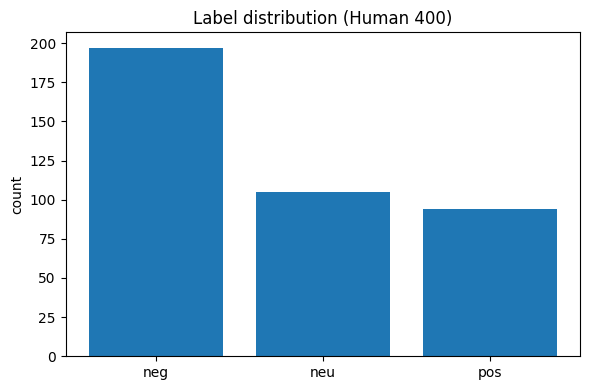

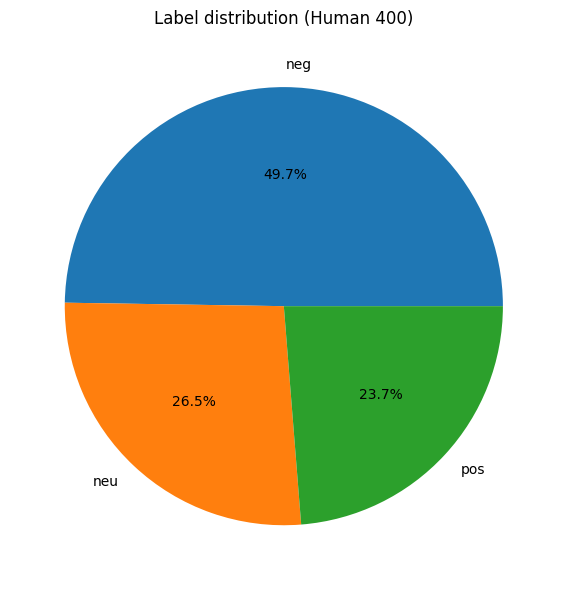

In [ ]:
counts = res_gold['true_label'].value_counts().reindex(classes, fill_value=0)

plt.figure(figsize=(6,4))
plt.bar(counts.index, counts.values)
plt.ylabel('count')
plt.title('Label distribution (Human 400)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%')
plt.title('Label distribution (Human 400)')
plt.tight_layout()
plt.show()


## Human400中抽取“结婚相关”评论并做分布图

Marriage subset size: 158


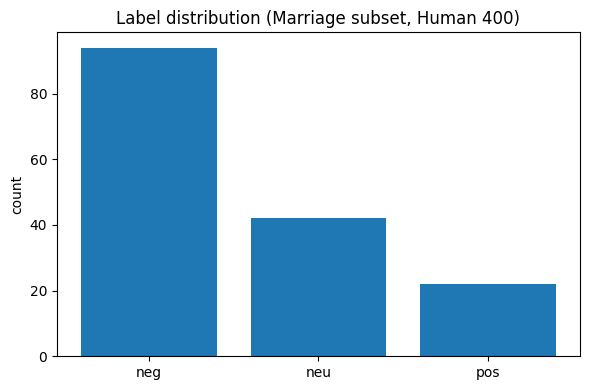

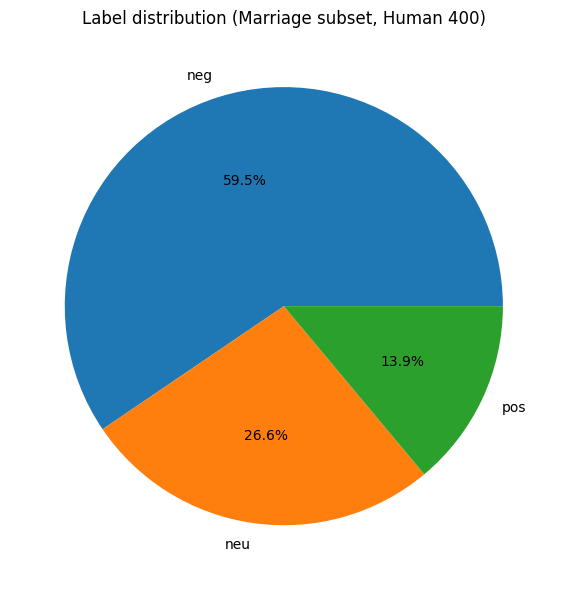

In [ ]:
MARRIAGE_KEYWORDS = [
    '结婚','婚姻','离婚','彩礼','嫁','娶','婚后','相亲','对象','恋爱','生孩子','生育','丁克','不婚','晚婚'
]

def contains_kw(text: str, kws) -> bool:
    t = str(text)
    return any(k in t for k in kws)

res_gold['is_marriage'] = res_gold['text'].apply(lambda x: contains_kw(x, MARRIAGE_KEYWORDS))
df_marriage = res_gold[res_gold['is_marriage']].copy()
print('Marriage subset size:', len(df_marriage))

if len(df_marriage) > 0:
    m_counts = df_marriage['true_label'].value_counts().reindex(classes, fill_value=0)
    plt.figure(figsize=(6,4))
    plt.bar(m_counts.index, m_counts.values)
    plt.ylabel('count')
    plt.title('Label distribution (Marriage subset, Human 400)')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,6))
    plt.pie(m_counts.values, labels=m_counts.index, autopct='%1.1f%%')
    plt.title('Label distribution (Marriage subset, Human 400)')
    plt.tight_layout()
    plt.show()


## 正/负词云

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
DEBUG:jieba:Loading model from cache /tmp/jieba.cache
Loading model cost 0.408 seconds.
DEBUG:jieba:Loading model cost 0.408 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


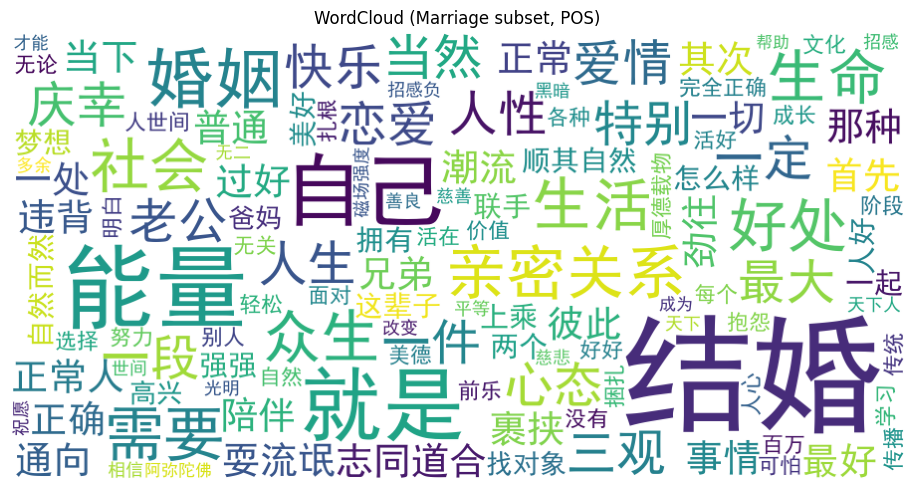

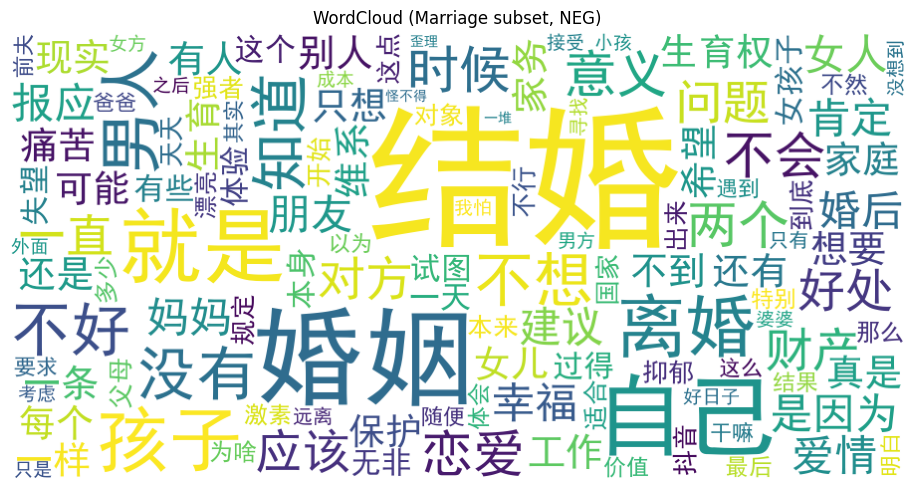

In [ ]:
from wordcloud import WordCloud
import jieba

FONT_PATH = '/content/simhei.ttf'
if not os.path.exists(FONT_PATH):
    print('⚠️ 找不到字体文件：', FONT_PATH, '（词云可能乱码）。')

stopwords = set('''
的 了 和 是 就 都 也 还 很 在 有 没 不 不是 可以 不能 能 会 要 不要
一个 一种 这些 那些 这样 那样 这种 我 你 他 她 它 我们 你们 他们
现在 以后 之前 已经 觉得 感觉 认为 如果 因为 所以 但是 而且 然后
什么 怎么 为什么 哪个
'''.split())

def clean_and_cut(text: str):
    text = re.sub(r"[^一-鿿]+", ' ', str(text))
    words = jieba.lcut(text)
    return [w for w in words if len(w) >= 2 and w not in stopwords]

def make_wordcloud(texts, title):
    words=[]
    for t in texts:
        words.extend(clean_and_cut(t))
    corpus = ' '.join(words)
    if corpus.strip() == '':
        print('（跳过）没有可用词：', title)
        return
    wc = WordCloud(
        font_path=FONT_PATH if os.path.exists(FONT_PATH) else None,
        width=900,
        height=450,
        background_color='white',
        max_words=120,
        collocations=False,
        min_word_length=2
    )
    plt.figure(figsize=(10,5))
    plt.imshow(wc.generate(corpus))
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.show()

if len(df_marriage) == 0:
    print('没有匹配到结婚相关评论，先检查关键词或数据内容。')
else:
    neg_label = 'neg' if 'neg' in classes else classes[0]
    pos_label = 'pos' if 'pos' in classes else classes[-1]

    make_wordcloud(df_marriage[df_marriage['true_label']==pos_label][TEXT_COL].tolist(),
                  f'WordCloud (Marriage subset, {pos_label.upper()})')
    make_wordcloud(df_marriage[df_marriage['true_label']==neg_label][TEXT_COL].tolist(),
                  f'WordCloud (Marriage subset, {neg_label.upper()})')
